# Zillow Project Group 1

by Qiucheng Wang & Xuheng Li

### Process Key Points:
1. Import and merge original data file. Deal with object/string type data.
2. Explore and select features based on their missing rates and importance ranks.
3. Transform data including encoding, normalization and scaling. Eliminate correlation and reduce dimension via PCA & LDA.
4. Fit model and tune parameters. Add extra features and prediction improves.

### Prediction Summary:
Sign of Logerror Classification

In [11]:
result = pd.DataFrame({'Adaboost': ['0.628 (+/-0.076)', '0.667 (+/-0.062)', '0.680 (+/-0.037)', '3-20 sec', '<1 sec'], 
                       'Logistics Regression': ['0.614 (+/-0.128)', '0.667 (+/-0.058) ', '0.673 (+/-0.053)', '10-20 sec', '<1 sec'], 
                       'SVM': ['-', '0.670 (+/-0.061)', '0.677 (+/-0.050)', '-', '2 min']}, 
                      index = ['F1 Score - Before LDA', 'F1 Score - After LDA', 'F1 Score - Add Prodesc',
                               'Running Time - Before LDA', 'Running Time - After LDA'])
result

,Adaboost,Logistics Regression,SVM
F1 Score - Before LDA,0.628 (+/-0.076),0.614 (+/-0.128),-
F1 Score - After LDA,0.667 (+/-0.062),0.667 (+/-0.058),0.670 (+/-0.061)
F1 Score - Add Prodesc,0.680 (+/-0.037),0.673 (+/-0.053),0.677 (+/-0.050)
Running Time - Before LDA,3-20 sec,10-20 sec,-
Running Time - After LDA,<1 sec,<1 sec,2 min


Logerror Regression

In [13]:
result = pd.DataFrame({'Linear Regression': ['Poor', 'Poor', 'Poor', 'Poor'], 
                       'Lasso Regression': ['-0.053 (+/- 0.008)', '-0.053 (+/- 0.008)', '0.005 (+/- 0.001)', '0.006 (+/- 0.001)'], 
                       'Adaboost': ['-0.058 (+/- 0.008)', '-0.061 (+/- 0.008)', '-0.062 (+/- 0.022)', '0.090 (+/- 0.032)']}, 
                      index = ['MAE - Before PCA', 'MAE - After PCA', 'R^2 - Before PCA', 'R^2 - After PCA'])
result

,Adaboost,Lasso Regression,Linear Regression
MAE - Before PCA,-0.058 (+/- 0.008),-0.053 (+/- 0.008),Poor
MAE - After PCA,-0.061 (+/- 0.008),-0.053 (+/- 0.008),Poor
R^2 - Before PCA,-0.062 (+/- 0.022),0.005 (+/- 0.001),Poor
R^2 - After PCA,0.090 (+/- 0.032),0.006 (+/- 0.001),Poor


### Findings:
1. Features with low missing rates tend to have higher importance.
2. Correlation elimination and dimension reduction via PCA & LDA improve prediction score and save running time.
3. Features related with tax, square size, room counts and location have higher coefficients in sign of logerror classification.
3. Features related with tax, square size and land use have higher coefficients in logerror regression.

# 1. Import Lib and Read Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics, decomposition, linear_model, svm, ensemble, discriminant_analysis, preprocessing, feature_selection

%matplotlib inline 

### 1.1. Merge label and feature data

Read original data

In [2]:
dp = pd.read_csv("./data/ref/origin/properties_2016.csv", low_memory=False)
dl = pd.read_csv("./data/ref/origin/train_2016_v2.csv", low_memory=False, parse_dates=['transactiondate'])
dic = pd.read_csv("./data/ref/origin/zillow_data_dictionary.csv", index_col=0, low_memory=False)

In [3]:
dl['logerrorsign'] = dl.logerror.apply(lambda x : 1 if x > 0 else -1)

In [4]:
d = dl.merge(dp, on = 'parcelid')
d.set_index('parcelid')
d.to_csv("./data/ref/data_merged.csv")

Merge training data with feature information

In [2]:
d = pd.read_csv("./data/ref/data_merged.csv", index_col=0, parse_dates=['transactiondate'])

In [6]:
d.head()

,parcelid,logerror,transactiondate,logerrorsign,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,-1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,-1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,-1,NaN,NaN,NaN,2.5,4.0,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


Convert True/False and Y/N into {1, -1}

In [7]:
# Convert True/False and Y/N into {1, -1}
d.fireplaceflag = d.fireplaceflag.apply(lambda x: 1 if x == True else 0)
d.hashottuborspa = d.hashottuborspa.apply(lambda x: 1 if x == True else 0)
d.taxdelinquencyflag = d.taxdelinquencyflag.apply(lambda x: 1 if x == 'Y' else 0)
dic.loc['fireplaceflag', 'Type'] = 'Categorical'
dic.loc['hashottuborspa', 'Type'] = 'Categorical'
dic.loc['taxdelinquencyflag', 'Type'] = 'Categorical'

In [3]:
d.propertycountylandusecode.head(10)

0    0100
1       1
2    0100
3    010C
4     122
5    0100
6    0100
7    1129
8      34
9      34
Name: propertycountylandusecode, dtype: object

In [4]:
d.propertyzoningdesc.head(10)

0      LARS
1       NaN
2      PSR6
3      LAR3
4       NaN
5    HBR3YY
6     CORH*
7       NaN
8       NaN
9       NaN
Name: propertyzoningdesc, dtype: object

Transfer string into int code

In [5]:
lbl = preprocessing.LabelEncoder()
d.propertycountylandusecode = lbl.fit_transform(list(d.propertycountylandusecode.values))
d.propertyzoningdesc = lbl.fit_transform(list(d.propertyzoningdesc.values))

In [6]:
len(np.unique(d.propertyzoningdesc))

1997

In [7]:
dic.loc[['propertycountylandusecode', 'propertyzoningdesc']]

,Description,Data Type,Predictor,Type
Feature,,,,
propertycountylandusecode,County land use code i.e. it's zoning at the c...,object,True,Categorical
propertyzoningdesc,Description of the allowed land uses (zoning) ...,object,True,Categorical


In [8]:
dcor = pd.DataFrame({'propertycountylandusecode': d.propertycountylandusecode, 'propertyzoningdesc': d.propertyzoningdesc})
dcor.corr()

,propertycountylandusecode,propertyzoningdesc
propertycountylandusecode,1.000000,0.758251
propertyzoningdesc,0.758251,1.000000


In [10]:
d.drop(['propertyzoningdesc'], axis=1, inplace=True)
dic.loc['propertyzoningdesc', 'Predictor'] = False

In [11]:
# Break transactiondate into month and weekday
d['month'] = d.transactiondate.dt.month
d['weekday'] = d.transactiondate.dt.weekday

In [12]:
# All samples' assessmentyears are equal to 2015 thus useless
len(np.unique(d.assessmentyear))

1

In [13]:
d.drop(['assessmentyear'], axis=1, inplace=True)
dic.loc['assessmentyear', 'Predictor'] = False

In [14]:
d = d.set_index('parcelid')
d.to_csv("./data/data_raw.csv")
d.head() 

,logerror,transactiondate,logerrorsign,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,month,weekday
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,0,122754.0,360170.0,237416.0,6735.88,0,NaN,6.037107e+13,1,4
14366692,-0.1684,2016-01-01,-1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,0,346458.0,585529.0,239071.0,10153.02,0,NaN,NaN,1,4
12098116,-0.0040,2016-01-01,-1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,0,61994.0,119906.0,57912.0,11484.48,0,NaN,6.037464e+13,1,4
12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,0,171518.0,244880.0,73362.0,3048.74,0,NaN,6.037296e+13,1,5
14432541,-0.0050,2016-01-02,-1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,0,169574.0,434551.0,264977.0,5488.96,0,NaN,6.059042e+13,1,5


Update dictionary

In [15]:
dic = dic.reset_index()

In [16]:
month_dic = pd.DataFrame([['month','Month of transaction', d.month.dtype,True,'Categorical']], index=[58], columns=['Feature', 'Description', 'Data Type', 'Predictor', 'Type'])
weekday_dic = pd.DataFrame([['weekday','Weekday of transaction', d.weekday.dtype,True,'Categorical']], index=[59], columns=['Feature', 'Description', 'Data Type', 'Predictor', 'Type'])
dic = dic.append(month_dic)
dic = dic.append(weekday_dic)

In [17]:
dic.to_csv("./data/ref/features_dictionary.csv")

# 2. Feature Exploration & Selection based on Missing & Importance

### 2.1. Check Missing Rate

In [18]:
d = pd.read_csv("./data/data_raw.csv", index_col=0, low_memory=False)
dic = pd.read_csv("./data/ref/features_dictionary.csv", index_col=0, low_memory=False)

In [19]:
cat = (dic[(dic.Type == "Categorical") & dic.Predictor]).Feature.tolist()
num = (dic[(dic.Type == "Numerical") & dic.Predictor]).Feature.tolist()

In [20]:
d = d[['logerror', 'logerrorsign'] + cat + num]
d.head()

,logerror,logerrorsign,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,decktypeid,fireplaceflag,hashottuborspa,heatingorsystemtypeid,pooltypeid10,...,roomcnt,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,1,1.0,NaN,NaN,NaN,0,0,2.0,NaN,...,0.0,1.0,NaN,NaN,1959.0,360170.0,122754.0,237416.0,6735.88,NaN
14366692,-0.1684,-1,NaN,NaN,NaN,NaN,0,0,NaN,NaN,...,0.0,NaN,NaN,NaN,2014.0,585529.0,346458.0,239071.0,10153.02,NaN
12098116,-0.0040,-1,1.0,NaN,NaN,NaN,0,0,2.0,NaN,...,0.0,1.0,NaN,NaN,1940.0,119906.0,61994.0,57912.0,11484.48,NaN
12643413,0.0218,1,1.0,NaN,NaN,NaN,0,0,2.0,NaN,...,0.0,1.0,NaN,NaN,1987.0,244880.0,171518.0,73362.0,3048.74,NaN
14432541,-0.0050,-1,NaN,NaN,NaN,NaN,0,0,NaN,NaN,...,8.0,NaN,NaN,NaN,1981.0,434551.0,169574.0,264977.0,5488.96,NaN


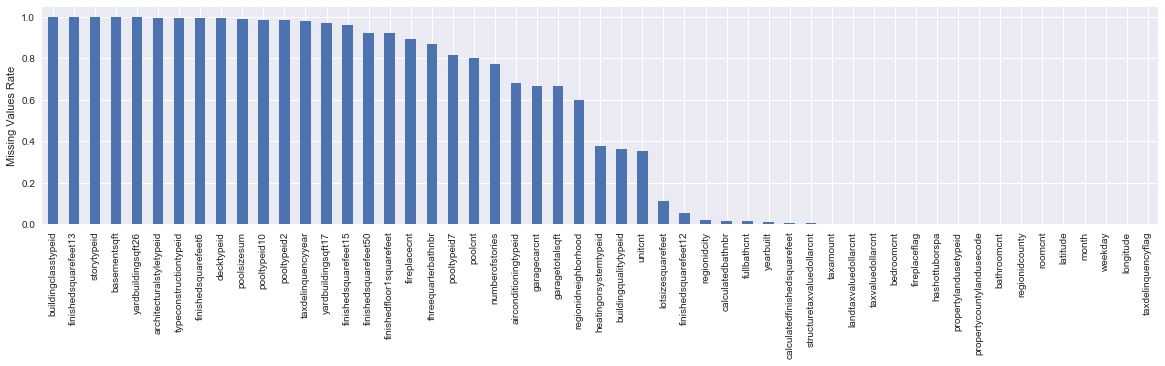

In [21]:
df = d.drop(['logerror', 'logerrorsign'], axis=1)
dm = df.isnull().sum()/len(d)
plt.ylabel('Missing Values Rate')
dm.sort_values(ascending=False).plot(figsize = (20, 4), kind='bar')

In [22]:
missing = pd.DataFrame()
missing['Feature'] = dm.index
missing['MissingRate'] = dm.values

### 2.2. Fill Missing Values

Categorical and Numercial Features Exploration

In [23]:
print(cat)
print(num)

['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'decktypeid', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'regionidcounty', 'regionidcity', 'regionidneighborhood', 'storytypeid', 'typeconstructiontypeid', 'taxdelinquencyflag', 'month', 'weekday']
['basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'threequarterbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet6', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'numberofstories', 'poolcnt', 'poolsizesum', 'roomcnt', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 't

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026700730550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000267052F6898>]], dtype=object)

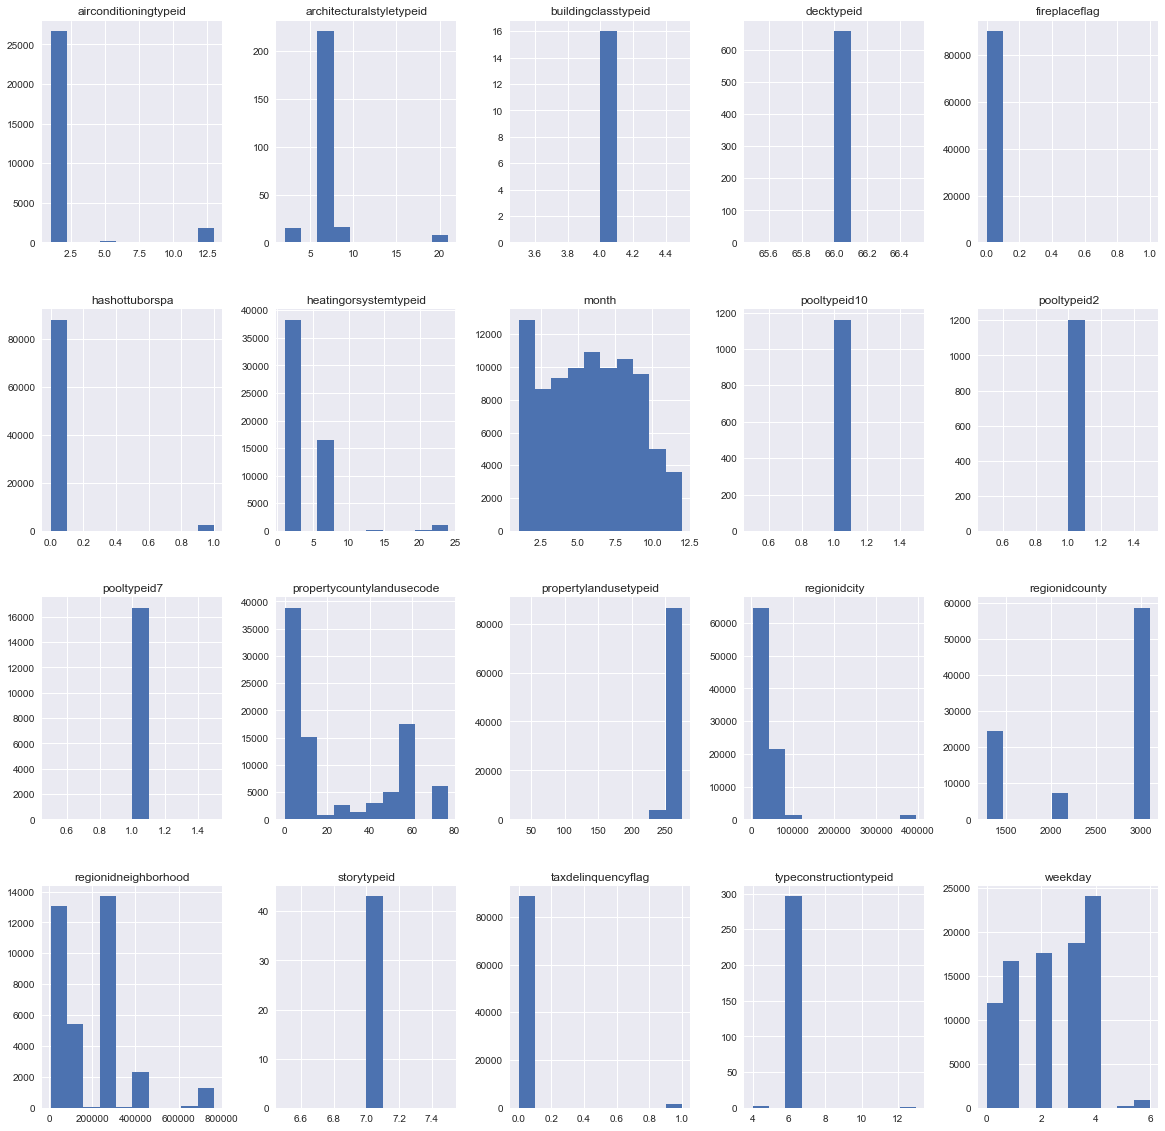

In [24]:
df[cat].hist(layout=(4, 5), figsize=(20, 20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002670B515208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002670BD2FF60>]], dtype=object)

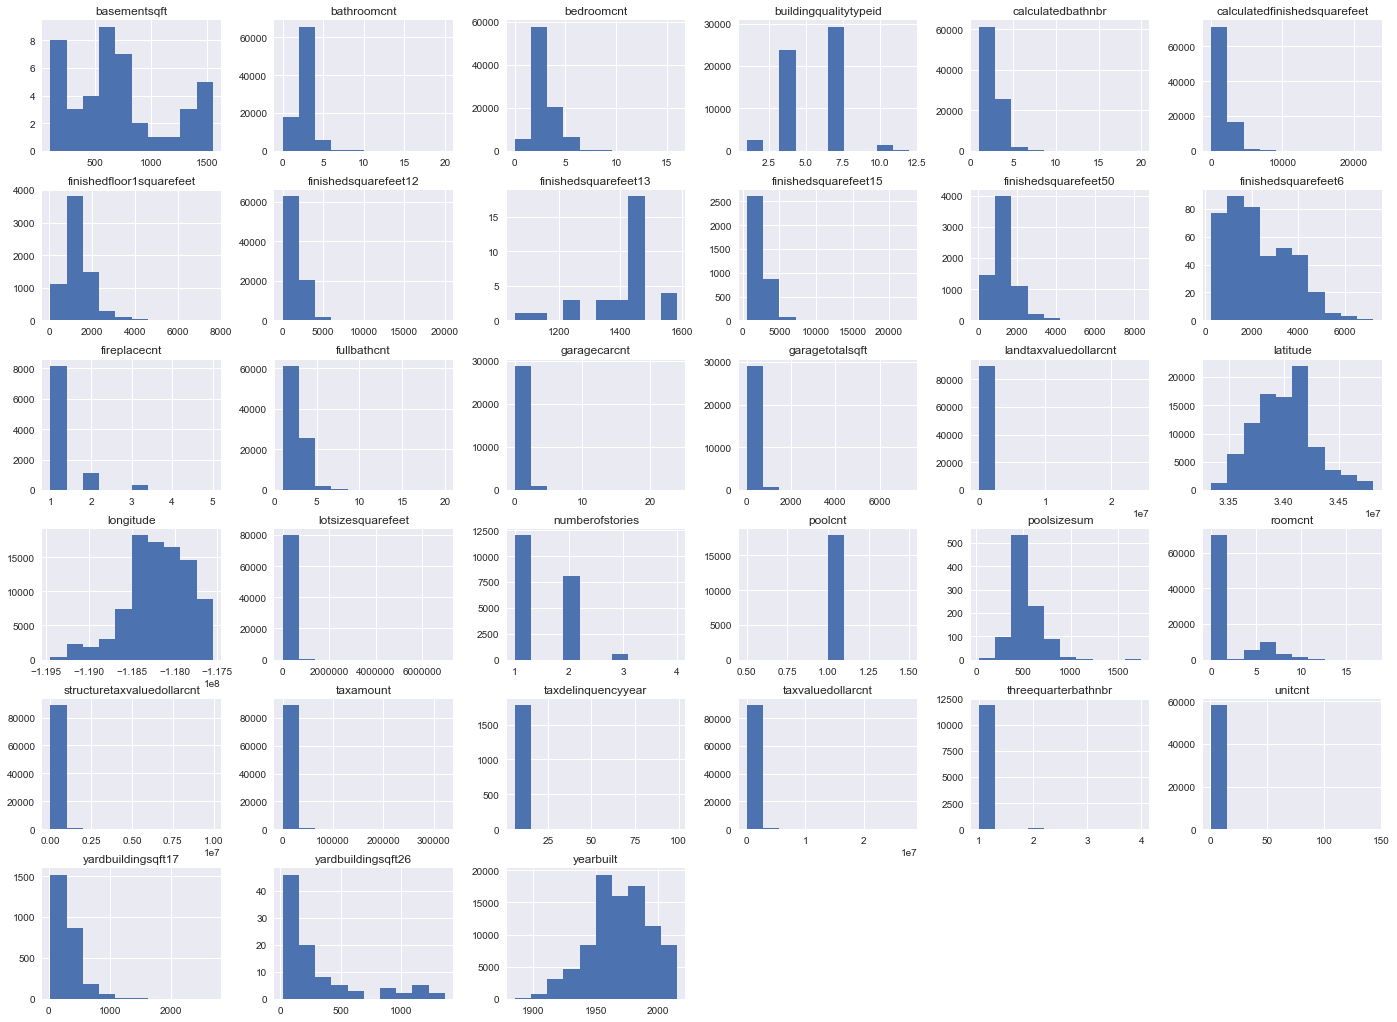

In [25]:
df[num].hist(layout=(6, 6), figsize=(24, 18))

Fill categorical features' na with -1 as a new subgroup

Fill poolcnt/fireplace/bathnbr/garage na with 0 since the na share fit the proporation of pool/fireplace/bathroom/garage ownership.

Fill other numerical features' na with median since large value outliers existed.

In [26]:
for f in cat:
    d[f].fillna(-1, inplace=True)

In [27]:
for f in ['poolcnt', 'poolsizesum', 'fireplacecnt', 'fullbathcnt', 'threequarterbathnbr', 'garagetotalsqft', 'garagecarcnt']:
    d[f].fillna(0, inplace=True)

In [28]:
for f in num:
    d[f].fillna(d[f].median(), inplace=True)

In [29]:
d.isnull().sum()

logerror                        0
logerrorsign                    0
airconditioningtypeid           0
architecturalstyletypeid        0
buildingclasstypeid             0
decktypeid                      0
fireplaceflag                   0
hashottuborspa                  0
heatingorsystemtypeid           0
pooltypeid10                    0
pooltypeid2                     0
pooltypeid7                     0
propertycountylandusecode       0
propertylandusetypeid           0
regionidcounty                  0
regionidcity                    0
regionidneighborhood            0
storytypeid                     0
typeconstructiontypeid          0
taxdelinquencyflag              0
month                           0
weekday                         0
basementsqft                    0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
threequarterbathnbr             0
finishedfloor1squarefeet        0
calculatedfini

In [30]:
d.to_csv('./data/data_filled.csv')

### 2.3. Use random forest to check feature importance

In [15]:
x_train = d.drop(['logerror', 'logerrorsign'], axis=1)
y_train = d['logerror']
ys_train = d['logerrorsign']

In [16]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
rfr = RandomForestRegressor(n_estimators=30, max_features=None)
rfc = RandomForestClassifier(n_estimators=30, max_features=None)
rfr.fit(x_train, y_train)
rfc.fit(x_train, ys_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [17]:
feature_importance = rfr.feature_importances_
feature_importance_sign = rfc.feature_importances_
importance = pd.DataFrame()
importance['Feature'] = x_train.columns
importance['Importance'] = feature_importance
importance['ImportanceSign'] = feature_importance_sign

In [18]:
importance_missing = importance.merge(missing, on = 'Feature')
importance_missing = importance_missing.reset_index(drop=True).set_index('Feature')
importance_missing.sort_values(by='Importance', ascending=False)

,Importance,ImportanceSign,MissingRate
Feature,,,
structuretaxvaluedollarcnt,0.088036,0.083705,0.004209
lotsizesquarefeet,0.084529,0.082466,0.112434
latitude,0.082493,0.084214,0.000000
longitude,0.079754,0.082196,0.000000
taxamount,0.078059,0.082281,0.000066
taxvaluedollarcnt,0.069586,0.069318,0.000011
landtaxvaluedollarcnt,0.068858,0.075933,0.000011
yearbuilt,0.058375,0.063847,0.008374
calculatedfinishedsquarefeet,0.053065,0.052541,0.007322


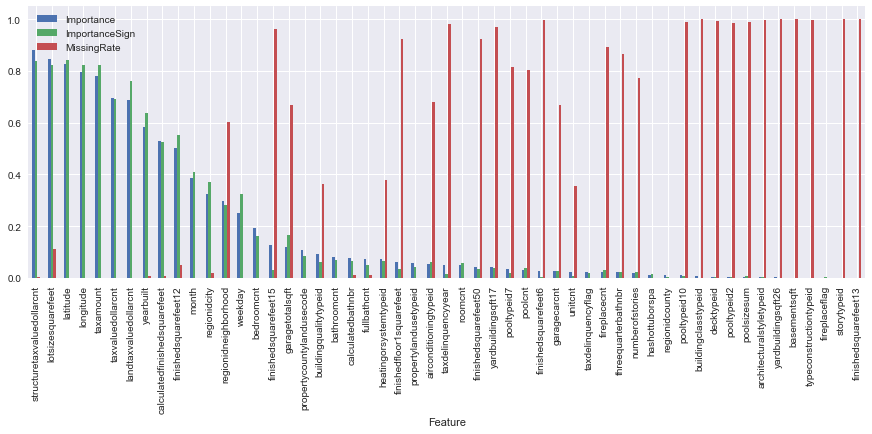

In [19]:
features_to_plot = importance_missing.sort_values(by='Importance', ascending=False)
features_to_plot.Importance = importance_missing.Importance * 10
features_to_plot.ImportanceSign = importance_missing.ImportanceSign * 10
features_to_plot.plot(figsize=(15, 5), kind='bar')

### 2.4. Apply RFE on Random Forest to Rank Features

In [20]:
rfe = feature_selection.RFE(estimator=rfr, verbose=1)
rfe_sign = feature_selection.RFE(estimator=rfc, verbose=1)

In [21]:
rfe.fit(x_train,y_train)

Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.


RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=1)

In [22]:
rfe_sign.fit(x_train,ys_train)

Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.


RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=1)

In [23]:
feature_rank = pd.DataFrame({'Feature': x_train.columns, 'Rank': rfe.ranking_})
feature_rank['Feature'] = x_train.columns
feature_rank['Rank'] = rfe.ranking_
feature_rank['RankSign'] = rfe_sign.ranking_

Add importance & missing into dictionary

In [24]:
importance_missing = importance_missing.reset_index()

In [25]:
dic_importance = dic.merge(importance_missing, on = "Feature")
dic_importance = dic_importance.reset_index(drop=True)
dic_importance = dic_importance.merge(feature_rank, on = "Feature")
dic_importance = dic_importance.reset_index(drop=True)
dic_importance = dic_importance.set_index('Feature')

In [26]:
dic_importance.to_csv("./data/feature_dic.csv")

### 2.5. Select Features

In [31]:
dic = pd.read_csv("./data/feature_dic.csv", low_memory=False)

In [32]:
dic[(dic.Rank < 11) & (dic.MissingRate >0.5)]

,Feature,Description,Data Type,Predictor,Type,Importance,ImportanceSign,MissingRate,Rank,RankSign
0,airconditioningtypeid,Type of cooling system present in the home (if...,float64,True,Categorical,0.005459,0.006242,0.681185,4,1
9,threequarterbathnbr,Number of 3/4 bathrooms in house (shower + sin...,float64,True,Numerical,0.002178,0.002502,0.866973,10,9
10,finishedfloor1squarefeet,Size of the finished living area on the first ...,float64,True,Numerical,0.006380,0.003496,0.924054,1,1
12,finishedsquarefeet6,Base unfinished and finished area,float64,True,Numerical,0.002835,0.000355,0.995336,9,19
15,finishedsquarefeet15,Total area,float64,True,Numerical,0.012922,0.003095,0.960521,1,6
16,finishedsquarefeet50,Size of the finished living area on the first ...,float64,True,Numerical,0.004388,0.003604,0.924054,1,4
20,garagecarcnt,Total number of garages on the lot including a...,float64,True,Numerical,0.002759,0.002607,0.668380,7,7
21,garagetotalsqft,Total number of square feet of all garages on ...,float64,True,Numerical,0.011903,0.016754,0.668380,1,1
28,poolcnt,Number of pools on the lot (if any),float64,True,Numerical,0.002948,0.003873,0.801706,5,1
32,pooltypeid7,Pool without hot tub,float64,True,Categorical,0.003478,0.002069,0.815043,8,12


In [33]:
dic[(dic.RankSign < 11) & (dic.MissingRate >0.5)]

,Feature,Description,Data Type,Predictor,Type,Importance,ImportanceSign,MissingRate,Rank,RankSign
0,airconditioningtypeid,Type of cooling system present in the home (if...,float64,True,Categorical,0.005459,0.006242,0.681185,4,1
9,threequarterbathnbr,Number of 3/4 bathrooms in house (shower + sin...,float64,True,Numerical,0.002178,0.002502,0.866973,10,9
10,finishedfloor1squarefeet,Size of the finished living area on the first ...,float64,True,Numerical,0.006380,0.003496,0.924054,1,1
15,finishedsquarefeet15,Total area,float64,True,Numerical,0.012922,0.003095,0.960521,1,6
16,finishedsquarefeet50,Size of the finished living area on the first ...,float64,True,Numerical,0.004388,0.003604,0.924054,1,4
17,fireplacecnt,Number of fireplaces in a home (if any),float64,True,Numerical,0.002338,0.002990,0.893581,13,5
20,garagecarcnt,Total number of garages on the lot including a...,float64,True,Numerical,0.002759,0.002607,0.668380,7,7
21,garagetotalsqft,Total number of square feet of all garages on ...,float64,True,Numerical,0.011903,0.016754,0.668380,1,1
28,poolcnt,Number of pools on the lot (if any),float64,True,Numerical,0.002948,0.003873,0.801706,5,1
37,regionidneighborhood,Neighborhood in which the property is located,float64,True,Categorical,0.029746,0.028146,0.601086,1,1


Select feature with high rank and reasonable missing rate

In [34]:
selected_features = dic.Feature[dic.Rank < 11]
dsf = d[selected_features].drop(
    ['finishedfloor1squarefeet', 'finishedsquarefeet6', 'finishedsquarefeet15', 'finishedsquarefeet50', 'regionidneighborhood', 'yardbuildingsqft17', 'taxdelinquencyyear']
    , axis=1)
selected_features = dsf.columns
dsf.head()

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,threequarterbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,garagecarcnt,...,propertylandusetypeid,regionidcity,roomcnt,yearbuilt,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,month,weekday
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,1.0,2.0,3.0,4.0,2.0,0.0,1684.0,1684.0,2.0,0.0,...,261.0,12447.0,0.0,1959.0,360170.0,122754.0,237416.0,6735.88,1,4
14366692,-1.0,3.5,4.0,7.0,3.5,1.0,2263.0,2263.0,3.0,2.0,...,261.0,32380.0,0.0,2014.0,585529.0,346458.0,239071.0,10153.02,1,4
12098116,1.0,3.0,2.0,4.0,3.0,0.0,2217.0,2217.0,3.0,0.0,...,261.0,47019.0,0.0,1940.0,119906.0,61994.0,57912.0,11484.48,1,4
12643413,1.0,2.0,2.0,4.0,2.0,0.0,839.0,839.0,2.0,0.0,...,266.0,12447.0,0.0,1987.0,244880.0,171518.0,73362.0,3048.74,1,5
14432541,-1.0,2.5,4.0,7.0,2.5,1.0,2283.0,2283.0,2.0,2.0,...,261.0,17686.0,8.0,1981.0,434551.0,169574.0,264977.0,5488.96,1,5


In [35]:
selected_features_sign = dic.Feature[dic.RankSign < 11]
dsfs = d[selected_features_sign].drop(
    ['finishedfloor1squarefeet', 'finishedsquarefeet15', 'finishedsquarefeet50', 'regionidneighborhood', 'yardbuildingsqft17']
    , axis=1)
selected_features_sign = dsfs.columns
dsfs.head()

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,threequarterbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,fullbathcnt,...,regionidcity,roomcnt,yearbuilt,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,month,weekday
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,1.0,2.0,3.0,4.0,2.0,0.0,1684.0,1684.0,0.0,2.0,...,12447.0,0.0,1959.0,360170.0,122754.0,237416.0,6735.88,0,1,4
14366692,-1.0,3.5,4.0,7.0,3.5,1.0,2263.0,2263.0,0.0,3.0,...,32380.0,0.0,2014.0,585529.0,346458.0,239071.0,10153.02,0,1,4
12098116,1.0,3.0,2.0,4.0,3.0,0.0,2217.0,2217.0,0.0,3.0,...,47019.0,0.0,1940.0,119906.0,61994.0,57912.0,11484.48,0,1,4
12643413,1.0,2.0,2.0,4.0,2.0,0.0,839.0,839.0,0.0,2.0,...,12447.0,0.0,1987.0,244880.0,171518.0,73362.0,3048.74,0,1,5
14432541,-1.0,2.5,4.0,7.0,2.5,1.0,2283.0,2283.0,0.0,2.0,...,17686.0,8.0,1981.0,434551.0,169574.0,264977.0,5488.96,0,1,5


In [36]:
print('Selected Features for Logerror: ')
print(selected_features.tolist())
print('Selected Features for Sign of Logerror: ')
print(selected_features_sign.tolist())

Selected Features for Logerror: 
['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'threequarterbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'regionidcity', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'month', 'weekday']
Selected Features for Sign of Logerror: 
['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'threequarterbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'propertycountylandusecode', 'propertylandusetypei

Among selected features, high correlation existed and PCA need to be applied later to eliminate correlation.

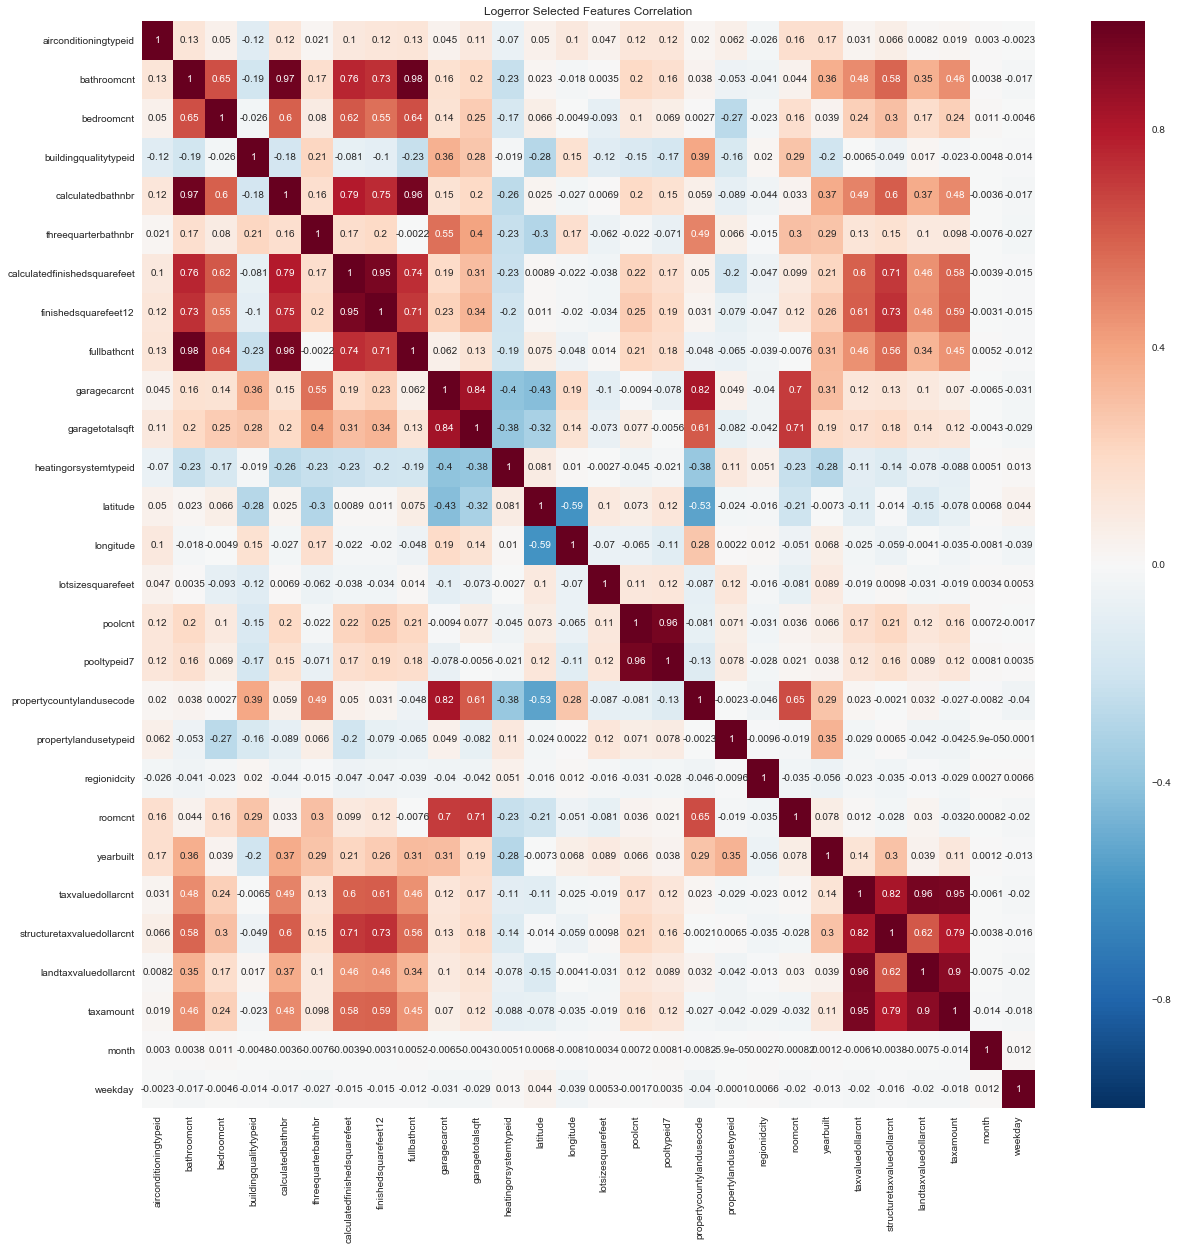

In [37]:
plt.figure(figsize =(20, 20))
plt.title('Logerror Selected Features Correlation')
sns.heatmap(dsf.corr(), annot=True)

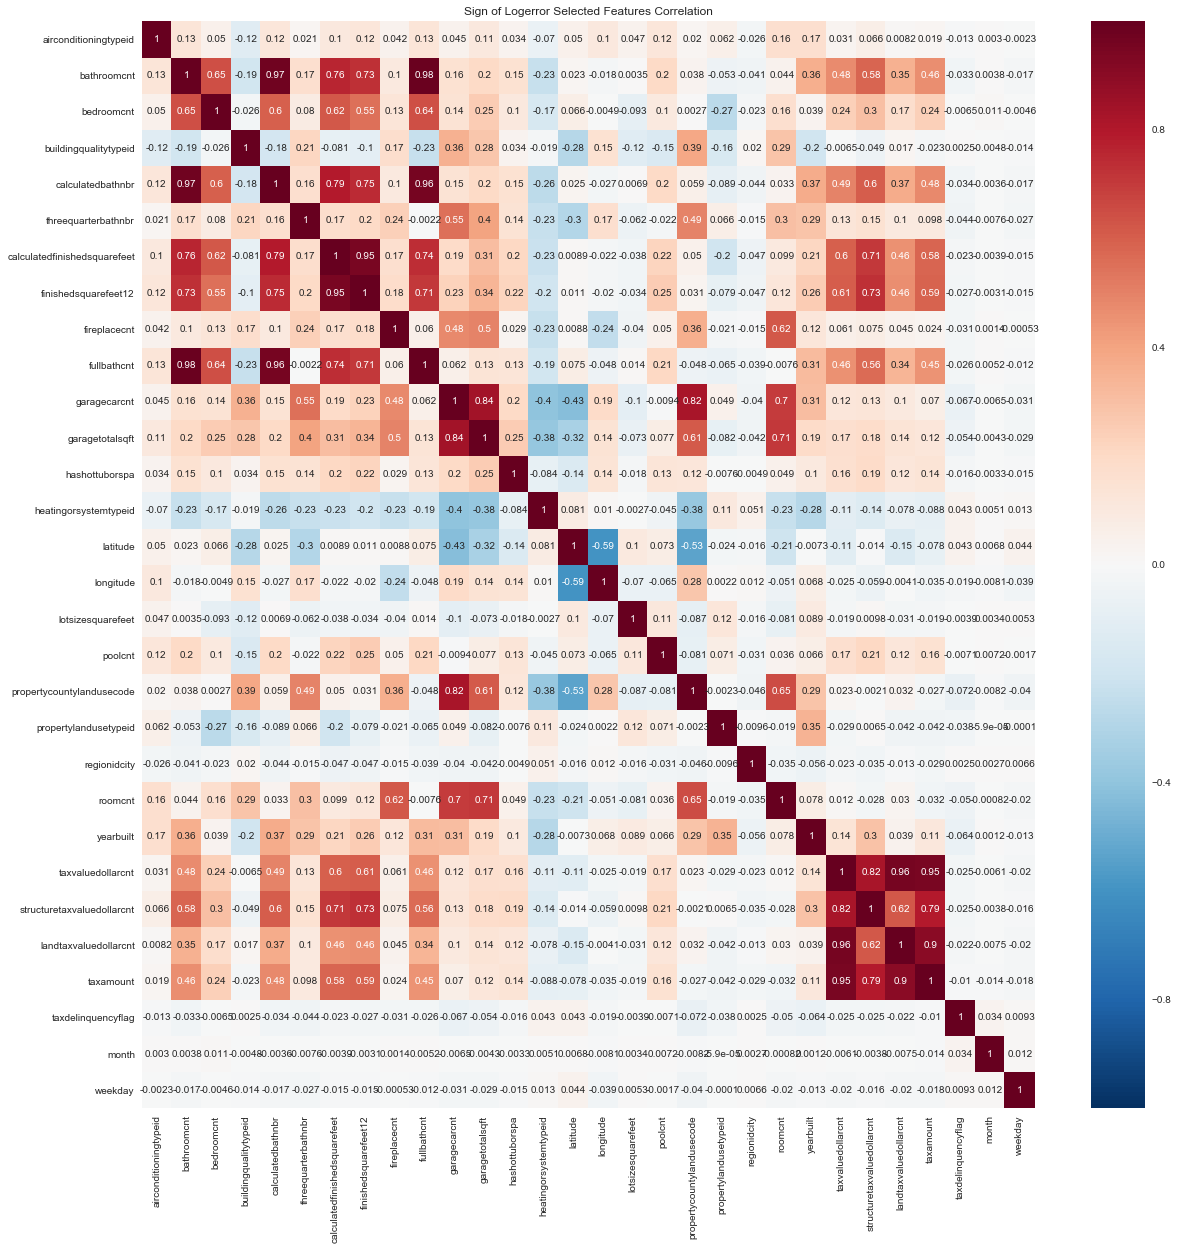

In [38]:
plt.figure(figsize =(20, 20))
plt.title('Sign of Logerror Selected Features Correlation')
sns.heatmap(dsfs.corr(), annot=True)

In [39]:
ds = d[['logerror'] + selected_features.tolist()]
ds.to_csv("./data/logerror/data_selected.csv")
ds.head()

,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,threequarterbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,...,propertylandusetypeid,regionidcity,roomcnt,yearbuilt,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,month,weekday
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,1.0,2.0,3.0,4.0,2.0,0.0,1684.0,1684.0,2.0,...,261.0,12447.0,0.0,1959.0,360170.0,122754.0,237416.0,6735.88,1,4
14366692,-0.1684,-1.0,3.5,4.0,7.0,3.5,1.0,2263.0,2263.0,3.0,...,261.0,32380.0,0.0,2014.0,585529.0,346458.0,239071.0,10153.02,1,4
12098116,-0.0040,1.0,3.0,2.0,4.0,3.0,0.0,2217.0,2217.0,3.0,...,261.0,47019.0,0.0,1940.0,119906.0,61994.0,57912.0,11484.48,1,4
12643413,0.0218,1.0,2.0,2.0,4.0,2.0,0.0,839.0,839.0,2.0,...,266.0,12447.0,0.0,1987.0,244880.0,171518.0,73362.0,3048.74,1,5
14432541,-0.0050,-1.0,2.5,4.0,7.0,2.5,1.0,2283.0,2283.0,2.0,...,261.0,17686.0,8.0,1981.0,434551.0,169574.0,264977.0,5488.96,1,5


In [40]:
dss = d[['logerrorsign'] + selected_features_sign.tolist()]
dss.to_csv("./data/sign/data_selected_sign.csv")
dss.head()

,logerrorsign,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,threequarterbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,...,regionidcity,roomcnt,yearbuilt,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,month,weekday
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,1,1.0,2.0,3.0,4.0,2.0,0.0,1684.0,1684.0,0.0,...,12447.0,0.0,1959.0,360170.0,122754.0,237416.0,6735.88,0,1,4
14366692,-1,-1.0,3.5,4.0,7.0,3.5,1.0,2263.0,2263.0,0.0,...,32380.0,0.0,2014.0,585529.0,346458.0,239071.0,10153.02,0,1,4
12098116,-1,1.0,3.0,2.0,4.0,3.0,0.0,2217.0,2217.0,0.0,...,47019.0,0.0,1940.0,119906.0,61994.0,57912.0,11484.48,0,1,4
12643413,1,1.0,2.0,2.0,4.0,2.0,0.0,839.0,839.0,0.0,...,12447.0,0.0,1987.0,244880.0,171518.0,73362.0,3048.74,0,1,5
14432541,-1,-1.0,2.5,4.0,7.0,2.5,1.0,2283.0,2283.0,0.0,...,17686.0,8.0,1981.0,434551.0,169574.0,264977.0,5488.96,0,1,5


# 3. Data Preprossing

In [2]:
d = pd.read_csv("./data/logerror/data_selected.csv", index_col=0, low_memory=False)
ds = pd.read_csv("./data/sign/data_selected_sign.csv", index_col=0, low_memory=False)
dic = pd.read_csv("./data/feature_dic.csv", low_memory=False)

In [3]:
dsorted = d.sort_values(by='logerror')
low = int(len(dsorted) * 0.01)
upper = int(len(dsorted) * 0.99)
d = dsorted[low: upper].sort_index()

In [62]:
# d = d.drop(['propertycountylandusecode', 'propertylandusetypeid', 'regionidcity'], axis=1)

In [4]:
df = d.drop(['logerror'], axis=1)
dfs = ds.drop(['logerrorsign'], axis=1)

In [5]:
cat_list = (dic[(dic.Type == "Categorical") & dic.Predictor]).Feature.tolist()
cat, cats, num, nums = [], [], [], []
for col in df.columns:
    cat.append(col) if col in cat_list else num.append(col)
for col in dfs.columns:
    cats.append(col) if col in cat_list else nums.append(col)

### 3.1. Data Transformation

Normlization

In [7]:
# Normlize skewed distributed features
df_norm = df.copy()
for n in num:
    if n not in ['latitude', 'longitude', 'yearbuilt']:
        df_norm[n] = np.log(df[n] + 1)

In [8]:
dfs_norm = dfs.copy()
for n in nums:
    if n not in ['latitude', 'longitude', 'yearbuilt']:
        dfs_norm[n] = np.log(dfs[n] + 1)

Scaling

In [9]:
from sklearn import preprocessing
sc = preprocessing.StandardScaler()
dfn_scaled = pd.DataFrame(sc.fit_transform(df_norm[num]), index = df_norm.index, columns = df_norm[num].columns)
dfns_scaled = pd.DataFrame(sc.fit_transform(dfs_norm[nums]), index = dfs_norm.index, columns = dfs_norm[nums].columns)

In [10]:
df_scaled = pd.concat([dfn_scaled, df_norm[cat]], axis=1)
dfs_scaled = pd.concat([dfns_scaled, dfs_norm[cats]], axis=1)

Encode

In [11]:
print('Logerror')
for f in cat:
    print('%s: %d' %(f, len(np.unique(df_scaled[f]))))
print('\nSign of Logerror')
for f in cats:
    print('%s: %d' %(f, len(np.unique(dfs_scaled[f]))))

Logerror
airconditioningtypeid: 7
heatingorsystemtypeid: 13
pooltypeid7: 2
propertycountylandusecode: 72
propertylandusetypeid: 13
regionidcity: 178
month: 12
weekday: 7

Sign of Logerror
airconditioningtypeid: 7
hashottuborspa: 2
heatingorsystemtypeid: 13
propertycountylandusecode: 78
propertylandusetypeid: 14
regionidcity: 178
taxdelinquencyflag: 2
month: 12
weekday: 7


In [12]:
df_encoded = pd.get_dummies(df_scaled, columns=cat, drop_first=True)
dfs_encoded = pd.get_dummies(dfs_scaled, columns=cats, drop_first=True)

In [13]:
for col in df_encoded:
    if col not in num:
        df_encoded[col] = df_encoded[col].apply(lambda x: -1 if x == 0 else 1)
for col in dfs_encoded:
    if col not in num:
        dfs_encoded[col] = dfs_encoded[col].apply(lambda x: -1 if x == 0 else 1)

In [14]:
d_transformed = pd.concat([d.logerror, df_encoded], axis=1)
d_transformed.head()

,logerror,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,threequarterbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,garagecarcnt,...,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
parcelid,,,,,,,,,,,,,,,,,,,,,
10711738,0.0276,0.799182,0.829072,-1.030028,0.830957,-0.393291,1.054812,1.122819,0.871515,-0.685964,...,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
10711755,-0.0182,0.799182,0.115252,-1.030028,0.830957,-0.393291,-0.010179,0.024356,0.871515,-0.685964,...,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
10711805,-0.1009,-0.147341,0.115252,-1.030028,-0.210244,-0.393291,0.938050,1.002387,-0.078573,-0.685964,...,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
10711816,-0.0121,-0.147341,0.829072,-1.030028,-0.210244,-0.393291,0.762589,0.821412,-0.078573,-0.685964,...,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
10711858,-0.0481,-0.147341,0.829072,-1.030028,-0.210244,-0.393291,0.374672,0.421303,-0.078573,-0.685964,...,-1,-1,-1,-1,-1,-1,-1,1,-1,-1


In [15]:
ds_transformed = pd.concat([ds.logerrorsign, dfs_encoded], axis=1)
ds_transformed.head()

,logerrorsign,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,threequarterbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,fullbathcnt,...,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,1,-0.141558,0.117146,-1.031873,-0.207276,-0.391002,0.120643,0.161216,1,-0.074042,...,-1,-1,-1,-1,-1,-1,-1,1,-1,-1
14366692,-1,1.178865,0.824170,0.525808,1.251363,2.533662,0.788363,0.851061,1,0.866373,...,-1,-1,-1,-1,-1,-1,-1,1,-1,-1
12098116,-1,0.795297,-0.794365,-1.031873,0.827645,-0.391002,0.741958,0.803118,1,0.866373,...,-1,-1,-1,-1,-1,-1,-1,1,-1,-1
12643413,1,-0.141558,-0.794365,-1.031873,-0.207276,-0.391002,-1.453032,-1.464602,1,-0.074042,...,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
14432541,-1,0.360443,0.824170,0.525808,0.347273,2.533662,0.808245,0.871602,1,-0.074042,...,-1,-1,-1,-1,-1,-1,-1,-1,1,-1


In [16]:
d_transformed.to_csv('./data/logerror/data_transformed.csv')
ds_transformed.to_csv('./data/sign/data_transformed_sign.csv')

### 3.2. Correlation Elimination & Dimension Reduction by PCA & LDA for Sign of Logerror 

In [17]:
d = pd.read_csv('./data/logerror/data_transformed.csv', index_col=0, low_memory=False)
ds = pd.read_csv('./data/sign/data_transformed_sign.csv', index_col=0, low_memory=False)

In [18]:
df = d.drop(['logerror'], axis=1)
dfs = ds.drop(['logerrorsign'], axis=1)
dt = d.logerror
dts = ds.logerrorsign

In [19]:
pca = decomposition.PCA()
pcas = decomposition.PCA()
lda = discriminant_analysis.LinearDiscriminantAnalysis()

In [20]:
df_pca = pca.fit_transform(df)
dfs_pca = pcas.fit_transform(dfs)

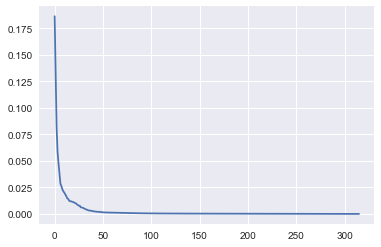

In [21]:
plt.plot(pca.explained_variance_ratio_)

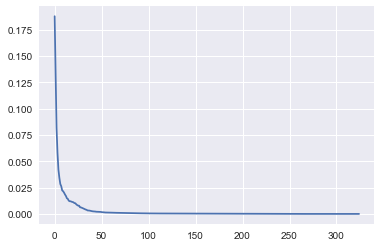

In [22]:
plt.plot(pcas.explained_variance_ratio_)

In [23]:
df_pca = pd.DataFrame(df_pca, index=d.index)
dfs_pca = pd.DataFrame(dfs_pca, index=ds.index)

In [24]:
dfs_lda = lda.fit_transform(dfs_pca, dts)
dfs_lda = pd.DataFrame(dfs_lda, index=ds.index, columns=['LDA'])

In [25]:
df_pca.to_csv("./data/logerror/df_pca.csv")
dfs_lda.to_csv("./data/sign/df_lda_sign.csv")

# 4. Modeling for Sign of Logerror

### 4.1. Data Split

In [2]:
d = pd.read_csv('./data/sign/data_transformed_sign.csv', index_col=0, low_memory=False)
y = d.logerrorsign
#Use Scaled data
x = d.drop(['logerrorsign'], axis=1)
#Use Scalded and LDA data
xl = pd.read_csv("./data/sign/df_lda_sign.csv", index_col=0, low_memory=False)

In [3]:
train_id, test_id = model_selection.train_test_split(d.index, test_size=0.2)

In [4]:
x_train = x.loc[train_id]
x_test = x.loc[test_id]
y_train = y.loc[train_id]
y_test = y.loc[test_id]
xl_train = xl.loc[train_id]
xl_test = xl.loc[test_id]

### 4.2. Fit Model

AdaBoost

In [29]:
ada = ensemble.AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
adal = ensemble.AdaBoostClassifier(n_estimators=15, learning_rate=0.75)

In [30]:
ada.fit(x_train, y_train)
adal.fit(xl_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.75, n_estimators=15, random_state=None)

In [31]:
y_pred = ada.predict(x_test)
yl_pred = adal.predict(xl_test)

In [32]:
print('Non LDA Accuracy:')
scores = model_selection.cross_val_score(ada, x, y, cv=5, verbose=1, n_jobs=5, scoring='f1')
print("Cross-Validated F1-Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
print()
print('LDA Accuracy:')
scores = model_selection.cross_val_score(adal, xl, y, cv=5, verbose=1, n_jobs=5, scoring='f1')
print("Cross-Validated F1-Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

Non LDA Accuracy:


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   41.8s remaining:  1.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   52.4s finished


Cross-Validated F1-Score: 0.609 (+/- 0.087)

LDA Accuracy:


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    7.8s remaining:   11.7s


Cross-Validated F1-Score: 0.649 (+/- 0.082)


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.4s finished


In [33]:
print("None LDA Report: ")
print(metrics.classification_report(y_test, y_pred, target_names=['Lower','Higher']))
print("LDA Report: ")
print(metrics.classification_report(y_test, yl_pred, target_names=['Lower','Higher']))

None LDA Report: 
             precision    recall  f1-score   support

      Lower       0.56      0.25      0.35      8222
     Higher       0.57      0.84      0.68      9873

avg / total       0.57      0.57      0.53     18095

LDA Report: 
             precision    recall  f1-score   support

      Lower       0.56      0.31      0.40      8222
     Higher       0.58      0.79      0.67      9873

avg / total       0.57      0.57      0.55     18095



Logistic Regression

In [34]:
lr = linear_model.LogisticRegression(C=0.01)
lrl = linear_model.LogisticRegression(C=0.01)

In [35]:
lr.fit(x_train, y_train)
lrl.fit(xl_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
y_pred = lr.predict(x_test)
yl_pred = lrl.predict(xl_test)

In [37]:
print('Non LDA Accuracy:')
scores = model_selection.cross_val_score(lr, x, y, cv=5, verbose=1, n_jobs=5, scoring="f1")
print("Cross-Validated F1-Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() ))
print()
print('LDA Accuracy:')
scores = model_selection.cross_val_score(lrl, xl, y, cv=5, verbose=1, n_jobs=5, scoring="f1")
print("Cross-Validated F1-Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() ))

Non LDA Accuracy:


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   25.6s remaining:   38.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   36.2s finished


Cross-Validated F1-Score: 0.612 (+/- 0.092)

LDA Accuracy:


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s


Cross-Validated F1-Score: 0.667 (+/- 0.035)


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   17.6s finished


In [38]:
print("None LDA Report: ")
print(metrics.classification_report(y_test, y_pred, target_names=['Lower','Higher']))
print("LDA Report: ")
print(metrics.classification_report(y_test, yl_pred, target_names=['Lower','Higher']))

None LDA Report: 
             precision    recall  f1-score   support

      Lower       0.55      0.29      0.38      8222
     Higher       0.57      0.80      0.67      9873

avg / total       0.56      0.57      0.54     18095

LDA Report: 
             precision    recall  f1-score   support

      Lower       0.56      0.31      0.40      8222
     Higher       0.58      0.79      0.67      9873

avg / total       0.57      0.58      0.55     18095



Intercept: [-0.00374823]
Coefficients:


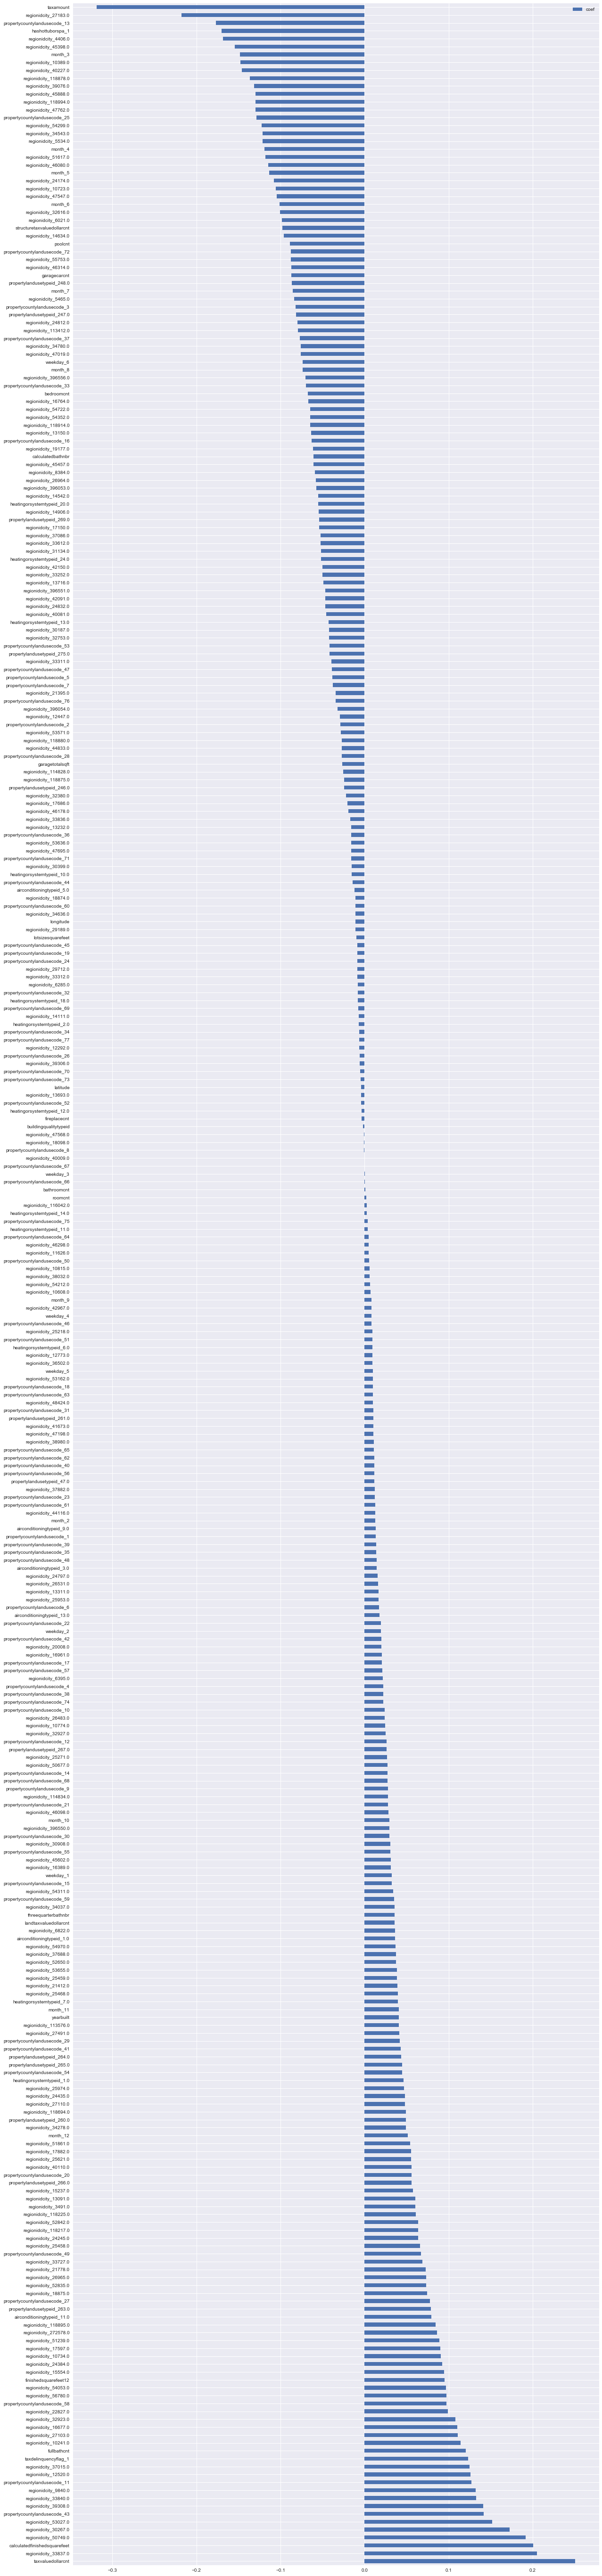

In [40]:
print('Intercept:',lr.intercept_)
print('Coefficients:')
coefs_df = pd.DataFrame(index=x_train.columns, data=lr.coef_[0], columns=['coef']);
coefs_df.sort_values('coef', ascending=False).plot.barh(figsize=(20, 100));

In [41]:
print(coefs_df.sort_values('coef', ascending=False).head(20))
print(coefs_df.sort_values('coef', ascending=False).tail(20))

                                  coef
taxvaluedollarcnt             0.250453
regionidcity_33837.0          0.205259
calculatedfinishedsquarefeet  0.200518
regionidcity_50749.0          0.191666
regionidcity_30267.0          0.172578
regionidcity_53027.0          0.151875
propertycountylandusecode_43  0.141625
regionidcity_39308.0          0.141146
regionidcity_33840.0          0.132787
regionidcity_9840.0           0.131910
propertycountylandusecode_11  0.126923
regionidcity_12520.0          0.125996
regionidcity_37015.0          0.124706
taxdelinquencyflag_1          0.123250
fullbathcnt                   0.120309
regionidcity_10241.0          0.114341
regionidcity_27103.0          0.110660
regionidcity_16677.0          0.110278
regionidcity_32923.0          0.108080
regionidcity_22827.0          0.098998
                                  coef
regionidcity_51617.0         -0.117912
month_4                      -0.119364
regionidcity_5534.0          -0.121140
regionidcity_34543.0     

Features related with tax, square sizes room counts and location have higher coefficients.

SVM

In [42]:
svm_model = svm.SVC(C=0.5, kernel='rbf', gamma='auto')

In [43]:
svm_model.fit(xl_train, y_train)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
yl_pred = svm_model.predict(xl_test)

In [45]:
print('LDA Accuracy:')
scores = model_selection.cross_val_score(svm_model, xl, y, cv=5, verbose=1, n_jobs=5, scoring="f1")
print("Cross-Validated F1-Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() ))

LDA Accuracy:


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.4min remaining:  8.1min


Cross-Validated F1-Score: 0.668 (+/- 0.038)


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.1min finished


In [46]:
print("LDA Report: ")
print(metrics.classification_report(y_test, yl_pred, target_names=['Lower','Higher']))

LDA Report: 
             precision    recall  f1-score   support

      Lower       0.56      0.29      0.39      8222
     Higher       0.58      0.81      0.68      9873

avg / total       0.57      0.58      0.54     18095



### 4.3. Parameter Tunning & Cross Validation

In [5]:
def report(clf):
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print(("%0.3f (+/-%0.03f) for %r")
              % (mean, std * 2, params))

In [20]:
tuned_parameters = {'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.5, 1.0, 1.5]}
ada_search = model_selection.RandomizedSearchCV(ensemble.AdaBoostClassifier(), verbose= 2, param_distributions=tuned_parameters, n_iter=12, scoring='f1')
adal_search = model_selection.RandomizedSearchCV(ensemble.AdaBoostClassifier(), verbose= 2, param_distributions=tuned_parameters, n_iter=12, scoring='f1')
ada_search.fit(x, y)
adal_search.fit(xl, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_estimators=10, learning_rate=0.5 ..............................
[CV] ............... n_estimators=10, learning_rate=0.5, total=   2.4s
[CV] n_estimators=10, learning_rate=0.5 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] ............... n_estimators=10, learning_rate=0.5, total=   2.4s
[CV] n_estimators=10, learning_rate=0.5 ..............................
[CV] ............... n_estimators=10, learning_rate=0.5, total=   2.4s
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] ............... n_estimators=50, learning_rate=0.5, total=  11.5s
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] ............... n_estimators=50, learning_rate=0.5, total=  11.4s
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] ............... n_estimators=50, learning_rate=0.5, total=  11.4s
[CV] n_estimators=100, learning_rate=0.5 .............................
[CV] .............. n_estimators=100, learning_rate=0.5, total=  22.6s
[CV] n_estimators=100, learning_rate=0.5 .............................
[CV] .............. n_estimators=100, learning_rate=0.5, total=  22.8s
[CV] n_estimators=100, learning_rate=0.5 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 13.4min finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_estimators=10, learning_rate=0.5 ..............................
[CV] ............... n_estimators=10, learning_rate=0.5, total=   0.2s
[CV] n_estimators=10, learning_rate=0.5 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............... n_estimators=10, learning_rate=0.5, total=   0.2s
[CV] n_estimators=10, learning_rate=0.5 ..............................
[CV] ............... n_estimators=10, learning_rate=0.5, total=   0.2s
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] ............... n_estimators=50, learning_rate=0.5, total=   1.2s
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] ............... n_estimators=50, learning_rate=0.5, total=   1.1s
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] ............... n_estimators=50, learning_rate=0.5, total=   1.2s
[CV] n_estimators=100, learning_rate=0.5 .............................
[CV] .............. n_estimators=100, learning_rate=0.5, total=   2.3s
[CV] n_estimators=100, learning_rate=0.5 .............................
[CV] .............. n_estimators=100, learning_rate=0.5, total=   2.4s
[CV] n_estimators=100, learning_rate=0.5 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.7min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params={}, iid=True, n_iter=12, n_jobs=1,
          param_distributions={'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.5, 1.0, 1.5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=2)

In [21]:
print("Non LDA Report:")
report(ada_search)
print("LDA Report:")
report(adal_search)

Non LDA Report:
Best parameters set found on development set:
{'n_estimators': 10, 'learning_rate': 0.5}

Grid scores on development set:

0.628 (+/-0.076) for {'n_estimators': 10, 'learning_rate': 0.5}
0.618 (+/-0.103) for {'n_estimators': 50, 'learning_rate': 0.5}
0.615 (+/-0.110) for {'n_estimators': 100, 'learning_rate': 0.5}
0.612 (+/-0.116) for {'n_estimators': 200, 'learning_rate': 0.5}
0.596 (+/-0.073) for {'n_estimators': 10, 'learning_rate': 1.0}
0.602 (+/-0.102) for {'n_estimators': 50, 'learning_rate': 1.0}
0.597 (+/-0.098) for {'n_estimators': 100, 'learning_rate': 1.0}
0.601 (+/-0.117) for {'n_estimators': 200, 'learning_rate': 1.0}
0.578 (+/-0.164) for {'n_estimators': 10, 'learning_rate': 1.5}
0.592 (+/-0.124) for {'n_estimators': 50, 'learning_rate': 1.5}
0.594 (+/-0.128) for {'n_estimators': 100, 'learning_rate': 1.5}
0.601 (+/-0.124) for {'n_estimators': 200, 'learning_rate': 1.5}
LDA Report:
Best parameters set found on development set:
{'n_estimators': 100, 'learni

In [6]:
tuned_parameters = {'C': [10, 1, 0.1, 0.01, 0.001]}
lr_search = model_selection.RandomizedSearchCV(linear_model.LogisticRegression(), verbose= 2, param_distributions=tuned_parameters, n_iter=5, scoring='f1')
lrl_search = model_selection.RandomizedSearchCV(linear_model.LogisticRegression(), verbose= 2, param_distributions=tuned_parameters, n_iter=5, scoring='f1')
lr_search.fit(x, y)
lrl_search.fit(xl, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=  50.7s
[CV] C=10 ............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.8s remaining:    0.0s


[CV] ............................................. C=10, total=  52.4s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=  51.4s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  27.4s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  30.4s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  32.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  14.4s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  13.9s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.4min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': [10, 1, 0.1, 0.01, 0.001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=2)

In [7]:
print("Non LDA Report:")
report(lr_search)
print("LDA Report:")
report(lrl_search)

Non LDA Report:
Best parameters set found on development set:
{'C': 0.001}

Grid scores on development set:

0.540 (+/-0.221) for {'C': 10}
0.544 (+/-0.221) for {'C': 1}
0.581 (+/-0.169) for {'C': 0.1}
0.603 (+/-0.144) for {'C': 0.01}
0.614 (+/-0.128) for {'C': 0.001}
LDA Report:
Best parameters set found on development set:
{'C': 0.001}

Grid scores on development set:

0.666 (+/-0.059) for {'C': 10}
0.666 (+/-0.059) for {'C': 1}
0.666 (+/-0.059) for {'C': 0.1}
0.666 (+/-0.058) for {'C': 0.01}
0.667 (+/-0.058) for {'C': 0.001}


In [28]:
tuned_parameters = {'kernel': ['rbf'], 'C': [0.01, 0.05, 0.1, 0.5, 1], 'gamma': ['auto']}
svm_search = model_selection.RandomizedSearchCV(svm.SVC(), verbose= 2, param_distributions=tuned_parameters, n_iter=5, scoring='f1')
svm_search.fit(xl, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] kernel=rbf, gamma=auto, C=0.01 ..................................
[CV] ................... kernel=rbf, gamma=auto, C=0.01, total= 2.2min
[CV] kernel=rbf, gamma=auto, C=0.01 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s


[CV] ................... kernel=rbf, gamma=auto, C=0.01, total= 2.2min
[CV] kernel=rbf, gamma=auto, C=0.01 ..................................
[CV] ................... kernel=rbf, gamma=auto, C=0.01, total= 2.2min
[CV] kernel=rbf, gamma=auto, C=0.05 ..................................
[CV] ................... kernel=rbf, gamma=auto, C=0.05, total= 2.3min
[CV] kernel=rbf, gamma=auto, C=0.05 ..................................
[CV] ................... kernel=rbf, gamma=auto, C=0.05, total= 2.3min
[CV] kernel=rbf, gamma=auto, C=0.05 ..................................
[CV] ................... kernel=rbf, gamma=auto, C=0.05, total= 2.3min
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] .................... kernel=rbf, gamma=auto, C=0.1, total= 2.3min
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] .................... kernel=rbf, gamma=auto, C=0.1, total= 2.3min
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 48.8min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'kernel': ['rbf'], 'C': [0.01, 0.05, 0.1, 0.5, 1], 'gamma': ['auto']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=2)

In [29]:
report(svm_search)

Best parameters set found on development set:
{'kernel': 'rbf', 'gamma': 'auto', 'C': 0.01}

Grid scores on development set:

0.670 (+/-0.061) for {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.01}
0.667 (+/-0.064) for {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.05}
0.667 (+/-0.065) for {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.1}
0.666 (+/-0.066) for {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.5}
0.665 (+/-0.067) for {'kernel': 'rbf', 'gamma': 'auto', 'C': 1}


Try to add 'propertyzoningdesc' back which has 2000 unique values

In [8]:
xl_new = pd.read_csv("./data/sign/df_lda_sign_2000.csv", index_col=0, low_memory=False)

In [7]:
tuned_parameters = {'n_estimators': [10, 25, 50, 100], 'learning_rate': [0.5, 0.75, 1.0]}
ada_search_new = model_selection.RandomizedSearchCV(ensemble.AdaBoostClassifier(), verbose= 2, param_distributions=tuned_parameters, n_iter=12, scoring='f1')
ada_search_new.fit(xl_new, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_estimators=10, learning_rate=0.5 ..............................
[CV] ............... n_estimators=10, learning_rate=0.5, total=   0.2s
[CV] n_estimators=10, learning_rate=0.5 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............... n_estimators=10, learning_rate=0.5, total=   0.2s
[CV] n_estimators=10, learning_rate=0.5 ..............................
[CV] ............... n_estimators=10, learning_rate=0.5, total=   0.2s
[CV] n_estimators=25, learning_rate=0.5 ..............................
[CV] ............... n_estimators=25, learning_rate=0.5, total=   0.5s
[CV] n_estimators=25, learning_rate=0.5 ..............................
[CV] ............... n_estimators=25, learning_rate=0.5, total=   0.6s
[CV] n_estimators=25, learning_rate=0.5 ..............................
[CV] ............... n_estimators=25, learning_rate=0.5, total=   0.5s
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] ............... n_estimators=50, learning_rate=0.5, total=   1.2s
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] ............... n_estimators=50, learning_rate=0.5, total=   1.1s
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   54.1s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params={}, iid=True, n_iter=12, n_jobs=1,
          param_distributions={'n_estimators': [10, 25, 50, 100], 'learning_rate': [0.5, 0.75, 1.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=2)

In [8]:
print("LDA Report:")
report(ada_search_new)

LDA Report:
Best parameters set found on development set:
{'n_estimators': 25, 'learning_rate': 1.0}

Grid scores on development set:

0.652 (+/-0.099) for {'n_estimators': 10, 'learning_rate': 0.5}
0.652 (+/-0.099) for {'n_estimators': 25, 'learning_rate': 0.5}
0.678 (+/-0.052) for {'n_estimators': 50, 'learning_rate': 0.5}
0.674 (+/-0.055) for {'n_estimators': 100, 'learning_rate': 0.5}
0.607 (+/-0.154) for {'n_estimators': 10, 'learning_rate': 0.75}
0.650 (+/-0.094) for {'n_estimators': 25, 'learning_rate': 0.75}
0.671 (+/-0.051) for {'n_estimators': 50, 'learning_rate': 0.75}
0.675 (+/-0.047) for {'n_estimators': 100, 'learning_rate': 0.75}
0.606 (+/-0.152) for {'n_estimators': 10, 'learning_rate': 1.0}
0.680 (+/-0.037) for {'n_estimators': 25, 'learning_rate': 1.0}
0.679 (+/-0.039) for {'n_estimators': 50, 'learning_rate': 1.0}
0.674 (+/-0.048) for {'n_estimators': 100, 'learning_rate': 1.0}


In [9]:
tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}
lr_search_new = model_selection.RandomizedSearchCV(linear_model.LogisticRegression(), verbose= 2, param_distributions=tuned_parameters, n_iter=5, scoring='f1')
lr_search_new.fit(xl_new, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': [0.001, 0.01, 0.1, 1, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=2)

In [10]:
report(lr_search_new)

Best parameters set found on development set:
{'C': 0.001}

Grid scores on development set:

0.673 (+/-0.053) for {'C': 0.001}
0.672 (+/-0.054) for {'C': 0.01}
0.671 (+/-0.054) for {'C': 0.1}
0.671 (+/-0.054) for {'C': 1}
0.671 (+/-0.054) for {'C': 10}


In [30]:
tuned_parameters = {'kernel': ['rbf'], 'C': [0.01, 0.05, 0.1, 0.5, 1], 'gamma': ['auto']}
svm_search_new = model_selection.RandomizedSearchCV(svm.SVC(), verbose= 2, param_distributions=tuned_parameters, n_iter=5, scoring='f1')
svm_search_new.fit(xl_new, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] kernel=rbf, gamma=auto, C=0.01 ..................................
[CV] ................... kernel=rbf, gamma=auto, C=0.01, total= 2.1min
[CV] kernel=rbf, gamma=auto, C=0.01 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV] ................... kernel=rbf, gamma=auto, C=0.01, total= 2.2min
[CV] kernel=rbf, gamma=auto, C=0.01 ..................................
[CV] ................... kernel=rbf, gamma=auto, C=0.01, total= 2.2min
[CV] kernel=rbf, gamma=auto, C=0.05 ..................................
[CV] ................... kernel=rbf, gamma=auto, C=0.05, total= 2.2min
[CV] kernel=rbf, gamma=auto, C=0.05 ..................................
[CV] ................... kernel=rbf, gamma=auto, C=0.05, total= 2.2min
[CV] kernel=rbf, gamma=auto, C=0.05 ..................................
[CV] ................... kernel=rbf, gamma=auto, C=0.05, total= 2.2min
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] .................... kernel=rbf, gamma=auto, C=0.1, total= 2.2min
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] .................... kernel=rbf, gamma=auto, C=0.1, total= 2.2min
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 45.5min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'kernel': ['rbf'], 'C': [0.01, 0.05, 0.1, 0.5, 1], 'gamma': ['auto']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=2)

In [31]:
report(svm_search_new)

Best parameters set found on development set:
{'kernel': 'rbf', 'gamma': 'auto', 'C': 0.01}

Grid scores on development set:

0.677 (+/-0.050) for {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.01}
0.676 (+/-0.052) for {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.05}
0.675 (+/-0.052) for {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.1}
0.674 (+/-0.053) for {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.5}
0.674 (+/-0.053) for {'kernel': 'rbf', 'gamma': 'auto', 'C': 1}


# 5. Modeling for Logerror

### 5.1. Data Split 

In [2]:
d = pd.read_csv('./data/logerror/data_transformed.csv', index_col=0, low_memory=False)
y = d.logerror
#Use Scaled data
x = d.drop(['logerror'], axis=1)
#Use Scalded and PCA data
xp = pd.read_csv("./data/logerror/df_pca.csv", index_col=0, low_memory=False)

In [3]:
train_id, test_id = model_selection.train_test_split(d.index, test_size=0.2)

In [4]:
x_train = x.loc[train_id]
x_test = x.loc[test_id]
y_train = y.loc[train_id]
y_test = y.loc[test_id]
xp_train = xp.loc[train_id]
xp_test = xp.loc[test_id]

### 5.2. Fit Model

Linear Regression

In [5]:
lr = linear_model.LinearRegression()
lrp = linear_model.LinearRegression()

In [36]:
lr.fit(x_train, y_train)
lrp.fit(xp_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Fitted model


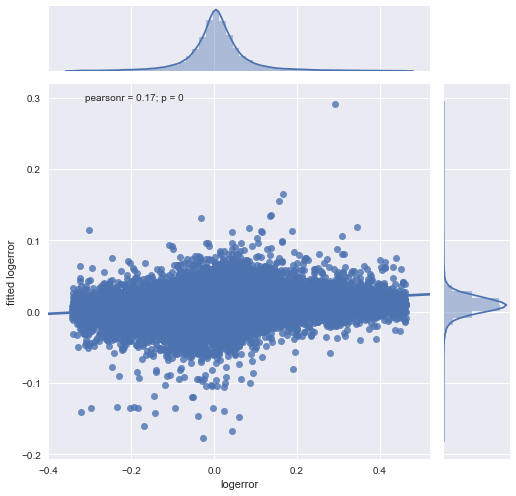

In [37]:
print("Fitted model")
y_fit = lr.predict(x_train)
g = sns.jointplot(y_train, y_fit, kind="reg", size=7);
g.set_axis_labels(xlabel="logerror",ylabel="fitted logerror");

Intercept: 69955798770.9
Coefficients:


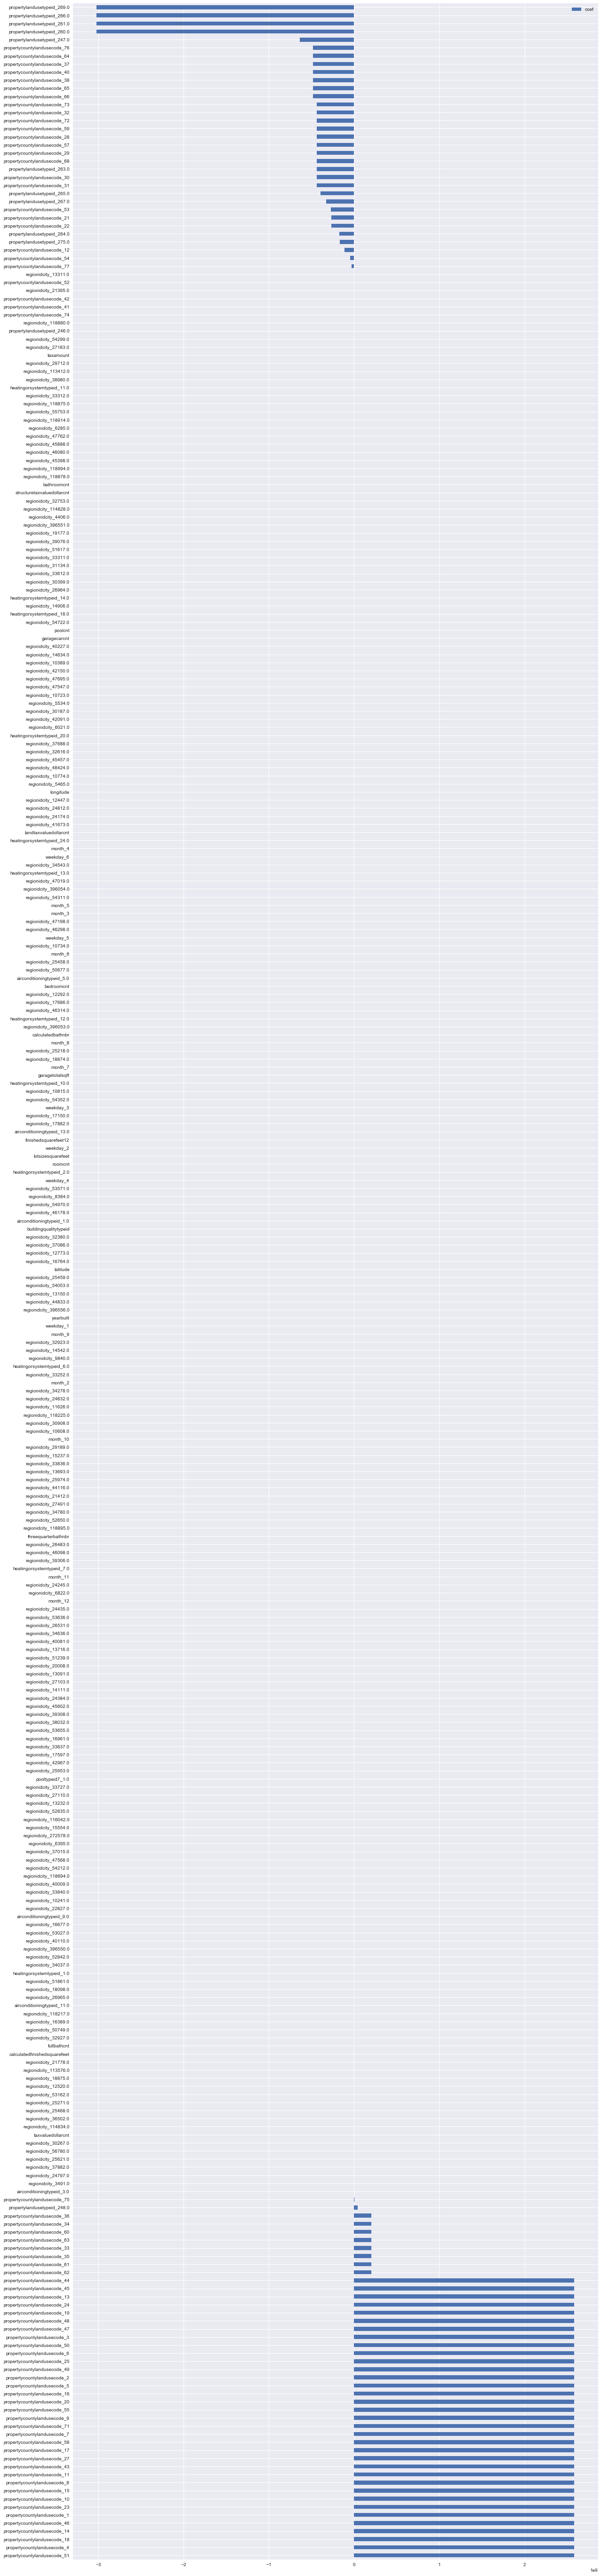

In [38]:
print('Intercept:',lr.intercept_)
print('Coefficients:')
coefs_df = pd.DataFrame(index=x_train.columns,data=lr.coef_, columns=['coef']);
coefs_df.sort_values('coef', ascending=False).plot.barh(figsize=(20, 100));

In [39]:
scores = model_selection.cross_val_score(lr, x, y, cv=5, scoring='neg_mean_absolute_error')
scoresp = model_selection.cross_val_score(lrp, xp, y, cv=5, scoring='neg_mean_absolute_error')
print("Non PCA Cross-Validated MAE Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
print("PCA Cross-Validated MAE Score: %0.3f (+/- %0.3f)" % (scoresp.mean(), scoresp.std()))

Non PCA Cross-Validated MAE Score: -107739472.487 (+/- 208476928.893)
PCA Cross-Validated MAE Score: -70826946586.179 (+/- 92135603105.496)


In [6]:
scores = model_selection.cross_val_score(lr, x, y, cv=5, scoring='r2')
scoresp = model_selection.cross_val_score(lrp, xp, y, cv=5, scoring='r2')
print("Non PCA Cross-Validated R^2 Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
print("PCA Cross-Validated R^2 Score: %0.3f (+/- %0.3f)" % (scoresp.mean(), scoresp.std()))

Non PCA Cross-Validated R^2 Score: -243001096540710141952.000 (+/- 482756587250315624448.000)
PCA Cross-Validated R^2 Score: -8422921260145868563021824.000 (+/- 13475642243600084491042816.000)


Lasso Regression

In [8]:
lar = linear_model.Lasso(alpha=0.001)
larp = linear_model.Lasso(alpha=0.001)

In [9]:
lar.fit(x_train, y_train)
larp.fit(xp_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Intercept: 0.00921533834862
Coefficients:


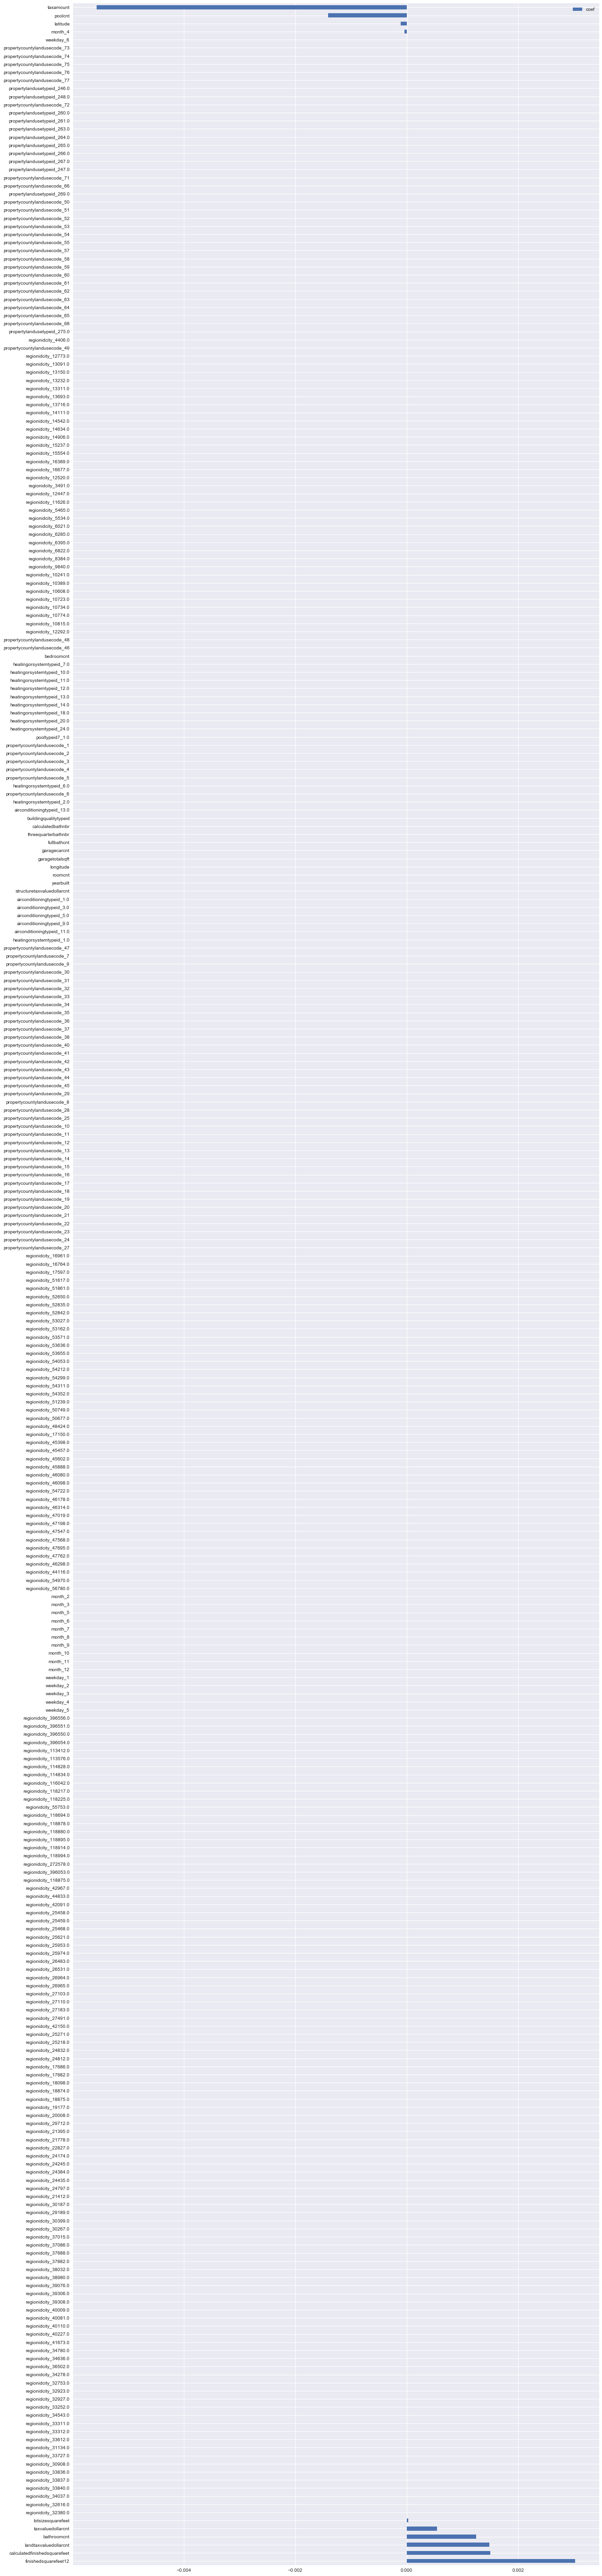

In [42]:
print('Intercept:',lar.intercept_)
print('Coefficients:')
coefs_df = pd.DataFrame(index=x_train.columns,data=lar.coef_, columns=['coef']);
coefs_df.sort_values('coef', ascending=False).plot.barh(figsize=(20, 100));

Features related with tax, square size and land use have higher coefficients. 

In [43]:
scores = model_selection.cross_val_score(lar, x, y, cv=5, scoring = 'neg_mean_absolute_error')
scoresp = model_selection.cross_val_score(larp, xp, y, cv=5, scoring = 'neg_mean_absolute_error')
print("Non PCA Cross-Validated MAE Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
print("PCA Cross-Validated MAE Score: %0.3f (+/- %0.3f)" % (scoresp.mean(), scoresp.std()))

Non PCA Cross-Validated MAE Score: -0.053 (+/- 0.008)
PCA Cross-Validated MAE Score: -0.053 (+/- 0.008)


In [10]:
scores = model_selection.cross_val_score(lar, x, y, cv=5, scoring='r2')
scoresp = model_selection.cross_val_score(larp, xp, y, cv=5, scoring='r2')
print("Non PCA Cross-Validated R^2 Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
print("PCA Cross-Validated R^2 Score: %0.3f (+/- %0.3f)" % (scoresp.mean(), scoresp.std()))

Non PCA Cross-Validated R^2 Score: 0.005 (+/- 0.001)
PCA Cross-Validated R^2 Score: 0.006 (+/- 0.001)


Adaboost

In [11]:
ada = ensemble.AdaBoostRegressor()
adap = ensemble.AdaBoostRegressor()

In [45]:
scores = model_selection.cross_val_score(ada, x, y, cv=5, scoring='neg_mean_absolute_error')
scoresp = model_selection.cross_val_score(adap, xp, y, cv=5, scoring='neg_mean_absolute_error')
print("Non PCA Cross-Validated MAE Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
print("PCA Cross-Validated MAE Score: %0.3f (+/- %0.3f)" % (scoresp.mean(), scoresp.std()))

Non PCA Cross-Validated MAE Score: -0.058 (+/- 0.008)
PCA Cross-Validated MAE Score: -0.061 (+/- 0.008)


In [12]:
scores = model_selection.cross_val_score(ada, x, y, cv=5, scoring='r2')
scoresp = model_selection.cross_val_score(adap, xp, y, cv=5, scoring='r2')
print("Non PCA Cross-Validated R^2 Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
print("PCA Cross-Validated R^2 Score: %0.3f (+/- %0.3f)" % (scoresp.mean(), scoresp.std()))

Non PCA Cross-Validated R^2 Score: -0.062 (+/- 0.022)
PCA Cross-Validated R^2 Score: -0.090 (+/- 0.032)


### 5.3. Parameter Tunning & Cross Validation

In [46]:
def report(reg):
    print("Best parameters set found on development set:")
    print(reg.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = reg.cv_results_['mean_test_score']
    stds = reg.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, reg.cv_results_['params']):
        print(("%0.3f (+/-%0.03f) for %r")
              % (mean, std * 2, params))
    print()
    print("Detailed regression report:")
    print()
    scores = model_selection.cross_val_score(reg.best_estimator_, x, y, cv=5, verbose=1, n_jobs=5, scoring="neg_mean_absolute_error")
    print("Cross-Validated MAE Score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() ))
    print()

In [47]:
tuned_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1]}
lar_search = model_selection.RandomizedSearchCV(linear_model.Lasso(), verbose= 2, param_distributions=tuned_parameters, n_iter=4)
lar_search.fit(xp, y)
report(lar_search)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.4s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ..................................... alpha=0.0001, total=   0.4s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.6s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.3s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.3s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.4s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.3s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.3s
[CV] alpha=0.01 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    6.1s finished


Best parameters set found on development set:
{'alpha': 0.0001}

Grid scores on development set:

0.010 (+/-0.007) for {'alpha': 0.0001}
0.007 (+/-0.003) for {'alpha': 0.001}
-0.001 (+/-0.001) for {'alpha': 0.01}
-0.001 (+/-0.001) for {'alpha': 0.1}

Detailed regression report:



[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   10.5s remaining:   15.8s


Cross-Validated MAE Score: -0.053 (+/- 0.008)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   18.7s finished


In [48]:
tuned_parameters = {'n_estimators': [50, 100, 150, 200], 'learning_rate': [0.5, 1.0, 1.5]}
ada_search = model_selection.RandomizedSearchCV(ensemble.AdaBoostRegressor(), verbose= 2, param_distributions=tuned_parameters, n_iter=12)
ada_search.fit(xp, y)
report(ada_search)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] ............... n_estimators=50, learning_rate=0.5, total= 3.8min
[CV] n_estimators=50, learning_rate=0.5 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s


[CV] ............... n_estimators=50, learning_rate=0.5, total= 3.7min
[CV] n_estimators=50, learning_rate=0.5 ..............................
[CV] ............... n_estimators=50, learning_rate=0.5, total= 2.6min
[CV] n_estimators=100, learning_rate=0.5 .............................
[CV] .............. n_estimators=100, learning_rate=0.5, total= 3.2min
[CV] n_estimators=100, learning_rate=0.5 .............................
[CV] .............. n_estimators=100, learning_rate=0.5, total= 1.8min
[CV] n_estimators=100, learning_rate=0.5 .............................
[CV] .............. n_estimators=100, learning_rate=0.5, total= 2.8min
[CV] n_estimators=150, learning_rate=0.5 .............................
[CV] .............. n_estimators=150, learning_rate=0.5, total= 3.2min
[CV] n_estimators=150, learning_rate=0.5 .............................
[CV] .............. n_estimators=150, learning_rate=0.5, total= 2.7min
[CV] n_estimators=150, learning_rate=0.5 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 67.6min finished


Best parameters set found on development set:
{'n_estimators': 100, 'learning_rate': 0.5}

Grid scores on development set:

-0.053 (+/-0.029) for {'n_estimators': 50, 'learning_rate': 0.5}
-0.039 (+/-0.036) for {'n_estimators': 100, 'learning_rate': 0.5}
-0.051 (+/-0.035) for {'n_estimators': 150, 'learning_rate': 0.5}
-0.048 (+/-0.021) for {'n_estimators': 200, 'learning_rate': 0.5}
-0.054 (+/-0.058) for {'n_estimators': 50, 'learning_rate': 1.0}
-0.080 (+/-0.046) for {'n_estimators': 100, 'learning_rate': 1.0}
-0.060 (+/-0.050) for {'n_estimators': 150, 'learning_rate': 1.0}
-0.057 (+/-0.042) for {'n_estimators': 200, 'learning_rate': 1.0}
-0.072 (+/-0.024) for {'n_estimators': 50, 'learning_rate': 1.5}
-0.067 (+/-0.031) for {'n_estimators': 100, 'learning_rate': 1.5}
-0.082 (+/-0.107) for {'n_estimators': 150, 'learning_rate': 1.5}
-0.049 (+/-0.016) for {'n_estimators': 200, 'learning_rate': 1.5}

Detailed regression report:



[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min


Cross-Validated MAE Score: -0.058 (+/- 0.007)



[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.3min finished
